**Import required libraries and scripts**

In [1]:
#Import required libraries and scripts
from scripts.library_preparation import *
from scripts.utilities import *
from scripts.docking_functions import *
from scripts.clustering_functions import *
from scripts.rescoring_functions import *
from scripts.ranking_functions import *
from scripts.performance_calculation import *
import numpy as np
import os

software = '/home/tony/CADD22/software'
protein_file = '/home/tony/CADD22/wocondock_main/2o1x_A_apo_protoss.pdb'
ref_file = '/home/tony/CADD22/wocondock_main/2o1x_A_lig_protoss.sdf'
docking_library = '/home/tony/CADD22/wocondock_main/Selection_of_FCHGroup_LeadLike.sdf'
docking_programs = ['GNINA', 'SMINA', 'PLANTS']
clustering_metrics = ['RMSD', 'spyRMSD', 'espsim', '3DScore', 'bestpose', 'bestpose_GNINA', 'bestpose_SMINA', 'bestpose_PLANTS']
rescoring_functions = ['gnina', 'AD4', 'chemplp', 'rfscorevs']
id_column = 'ID'
n_poses = 10
exhaustiveness = 4

#Initialise variables and create a temporary folder
w_dir = os.path.dirname(protein_file)
print('The working directory has been set to:', w_dir)
create_temp_folder(w_dir+'/temp')

[14:58:20] Initializing Normalizer


The working directory has been set to: /home/tony/CADD22/wocondock_main
The folder: /home/tony/CADD22/wocondock_main/temp already exists


In [ ]:
pocket_definition = binding_site_coordinates_dogsitescorer(protein_file, w_dir, method='volume')

In [2]:
cleaned_pkasolver_df = prepare_library(docking_library, id_column, software, 'pkasolver')

Standardizing docking library using ChemBL Structure Pipeline...


100%|██████████| 10/10 [00:00<00:00, 380.99it/s]

Standardization of compound library finished: Started with 10, ended with 10 : 0 compounds lost


Calculating protonation states using pkaSolver...


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


CN(C)c1nc(Cc2nnn[nH]2)cs1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

CN(C)c1nc(Cc2nnn[nH]2)cs1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: CN(C)c1nc(Cc2nnn[nH]2)cs1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Cc1nc(SCc2cc(=O)n3ccsc3n2)c2ccccc2n1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Cc1nc(SCc2cc(=O)n3ccsc3n2)c2ccccc2n1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: Cc1nc(SCc2cc(=O)n3ccsc3n2)c2ccccc2n1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Cn1cccc1C(=O)OCc1ccccc1C#N

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Cn1cccc1C(=O)OCc1ccccc1C#N

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: Cn1cccc1C(=O)OCc1ccccc1C#N
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


C[C@H](OC(=O)c1cc2c(s1)CCC2)c1nc2ccccc2c(=O)[nH]1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

C[C@H](OC(=O)c1cc2c(s1)CCC2)c1nc2ccccc2c(=O)[nH]1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: C[C@H](OC(=O)c1cc2c(s1)CCC2)c1nc2ccccc2c(=O)[nH]1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


CC(=O)NCc1ccc(C(=O)COC(=O)c2cc3c(s2)CCCCC3)o1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

CC(=O)NCc1ccc(C(=O)COC(=O)c2cc3c(s2)CCCCC3)o1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: CC(=O)NCc1ccc(C(=O)COC(=O)c2cc3c(s2)CCCCC3)o1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


CCN(C(=O)COc1cccc(-n2cnnn2)c1)c1cccc2ccccc12

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

CCN(C(=O)COc1cccc(-n2cnnn2)c1)c1cccc2ccccc12

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: CCN(C(=O)COc1cccc(-n2cnnn2)c1)c1cccc2ccccc12


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Cn1c(Cc2ccccc2)nnc1SCc1nc2ccsc2c(=O)[nH]1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Cn1c(Cc2ccccc2)nnc1SCc1nc2ccsc2c(=O)[nH]1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: Cn1c(Cc2ccccc2)nnc1SCc1nc2ccsc2c(=O)[nH]1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


N#Cc1ccc(CSc2nnc(CN3CCCC3)o2)cc1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

N#Cc1ccc(CSc2nnc(CN3CCCC3)o2)cc1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: N#Cc1ccc(CSc2nnc(C[NH+]3CCCC3)o2)cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Cc1noc(C)c1CSCC(=O)Nc1ccccc1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Cc1noc(C)c1CSCC(=O)Nc1ccccc1

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: Cc1noc(C)c1CSCC(=O)Nc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


CC1CCCC(NC(=O)Cn2nnc(-c3ccccc3Br)n2)C1C

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

CC1CCCC(NC(=O)Cn2nnc(-c3ccccc3Br)n2)C1C

For help, use: python dimorphite_dl.py --help

If you use Dimorphite-DL in your research, please cite:
Ropp PJ, Kaminsky JC, Yablonski S, Durrant JD (2019) Dimorphite-DL: An
open-source program for enumerating the ionization states of drug-like small
molecules. J Cheminform 11:14. doi:10.1186/s13321-019-0336-9.

Proposed mol at pH 7.4: CC1CCCC(NC(=O)Cn2nnc(-c3ccccc3Br)n2)C1C
0    States(pka=3.22906533241272, pka_stddev=0.8296...
1    States(pka=2.921631546020508, pka_stddev=0.480...
3    States(pka=4.610538291931152, pka_stddev=1.070...
4    States(pka=5.085016546249389, pka_stddev=0.934...
5    S

In [ ]:
all_poses = docking(protein_file, ref_file, software, docking_programs, exhaustiveness, n_poses)

In [5]:
docking_splitted(w_dir, protein_file, ref_file, software, docking_programs, exhaustiveness, n_poses)

Splitting SDF file final_library.sdf ...
The folder: /home/tony/CADD22/wocondock_main/temp/split_final_library was created
Split docking library into 5 files each containing 2 compounds
The folder: /home/tony/CADD22/wocondock_main/temp/plants was created
Converting protein file to .mol2 format for PLANTS docking...
Converting reference file from .sdf to .mol2 format for PLANTS docking...
Determining binding site coordinates using PLANTS...
Docking split files using PLANTS...


Docking with PLANTS: 100%|██████████| 5/5 [00:56<00:00, 11.27s/it]


Docking with PLANTS complete in 57.2874!
Docking split files using SMINA...


Docking with SMINA: 100%|██████████| 5/5 [01:00<00:00, 12.01s/it]


Docking with SMINA complete in 60.1454!
Docking split files using GNINA...


Docking with GNINA: 100%|██████████| 5/5 [01:25<00:00, 17.02s/it]

Docking with GNINA complete in 85.1807!


Fetching docking poses...


Loading GNINA poses: 100%|██████████| 5/5 [00:00<00:00, 90.97it/s]


Combining all poses...
Combined all docking poses in 0.7080!


,ID,CHEMPLP,Molecule,Pose ID,SMINA_Affinity,GNINA_Affinity,CNNscore,CNNaffinity,CNN_VS
0,FCG1390566,-71.9051,,FCG1390566_PLANTS_01,NaN,NaN,NaN,NaN,NaN
1,FCG1390566,-67.2674,,FCG1390566_PLANTS_02,NaN,NaN,NaN,NaN,NaN
2,FCG1390566,-66.3932,,FCG1390566_PLANTS_03,NaN,NaN,NaN,NaN,NaN
3,FCG1390566,-63.7682,,FCG1390566_PLANTS_04,NaN,NaN,NaN,NaN,NaN
4,FCG1390566,-63.1031,,FCG1390566_PLANTS_05,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
15,FCG16600623,NaN,,FCG16600623_GNINA_6,NaN,-9.14017,0.6006399989,6.6158466339,3.9737420082
16,FCG16600623,NaN,,FCG16600623_GNINA_7,NaN,-7.62252,0.5897314548,6.2356615067,3.6773657799
17,FCG16600623,NaN,,FCG16600623_GNINA_8,NaN,-7.72609,0.5754415393,6.4311151505,3.7007308006
18,FCG16600623,NaN,,FCG16600623_GNINA_9,NaN,12.99210,0.5279641747,5.8416748047,3.0841948986

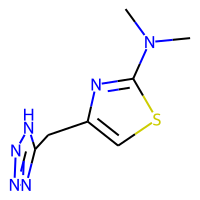
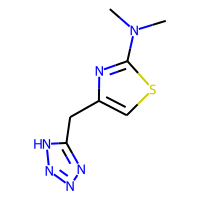
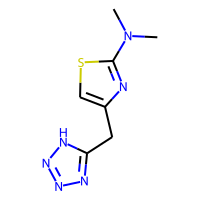
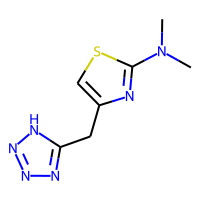
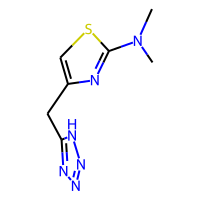
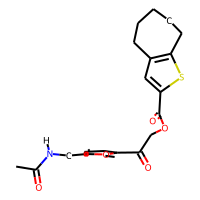
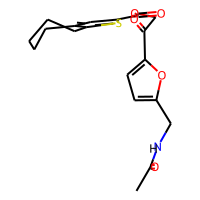
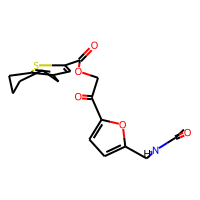
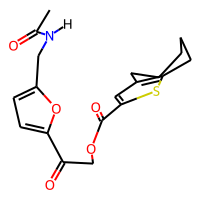
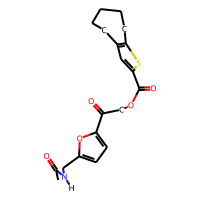

In [6]:
fetch_poses_splitted(w_dir, n_poses, split_files_folder=w_dir+'/temp/split_final_library')

In [ ]:
print('Loading all poses SDF file...')
tic = time.perf_counter()
all_poses = PandasTools.LoadSDF(w_dir+'/temp/allposes.sdf', idName='Pose ID', molColName='Molecule', includeFingerprints=False, strictParsing=True)
toc = time.perf_counter()
print(f'Finished loading all poses SDF in {toc-tic:0.4f}!...')

In [ ]:
for metric in clustering_metrics:
    cluster_mp(f'{metric}', 'KMedoids', w_dir, protein_file, all_poses)

**Rescoring**

The file containing all the cluster centers is then rescored using all scoring functions available (GNINA, Vina, AutoDock4, PLP, CHEMPLP, RF-Score-VS). The rescored output is return as a dataframe.

In [ ]:
for metric in clustering_metrics:
    rescore_all(w_dir, protein_file, ref_file, software, w_dir+f'/temp/clustering/{metric}_clustered.sdf', rescoring_functions, 0)


**Final ranking methods**

This code calculates the final ranking of compounds using various methods.
*Method 1* : Calculates ECR value for each cluster center, then outputs the top ranked center.
*Method 2* : Calculates ECR value for each cluster center, then outputs the average ECR value for each compound.
*Method 3* : Calculates the average rank of each compound, then ouputs the corresponding ECR value for each compound.
*Method 6* : Calculates Z-score for each cluster center, then ouputs the top ranked center.
*Method 7* : Calculates Z-score for each cluster center, then ouputs the average Z-score for each compound.

All methods are then combined into a single dataframe for comparison purposes.

In [ ]:
apply_consensus_methods(w_dir, ['bestpose_GNINA', 'bestpose_SMINA', 'bestpose_PLANTS'])

In [ ]:
calculate_EFs(w_dir, docking_library)